# Effect of promotions on customer conversion and retension
- This notebook aims to visualise and analyse the effect of promotions on customer conversion. 
- Firstly, the data is loaded into a pandas dataframe, then using graphs, the data is visualised using plots and matrices. Finally, various machine learning tools are used to identify customer conversion.

In [15]:
import numpy as np
import pandas as pd
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold as RSF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC

In [4]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


- Describes the dataset
- This gives us the count of not-empty values, the mean, the standard deviation, the minimum value and other statistics in the dataset
- The below description tells us that there are 64,000 potential customers, out of which 14\% converted to actual customers

In [6]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


# Graphs

In [22]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


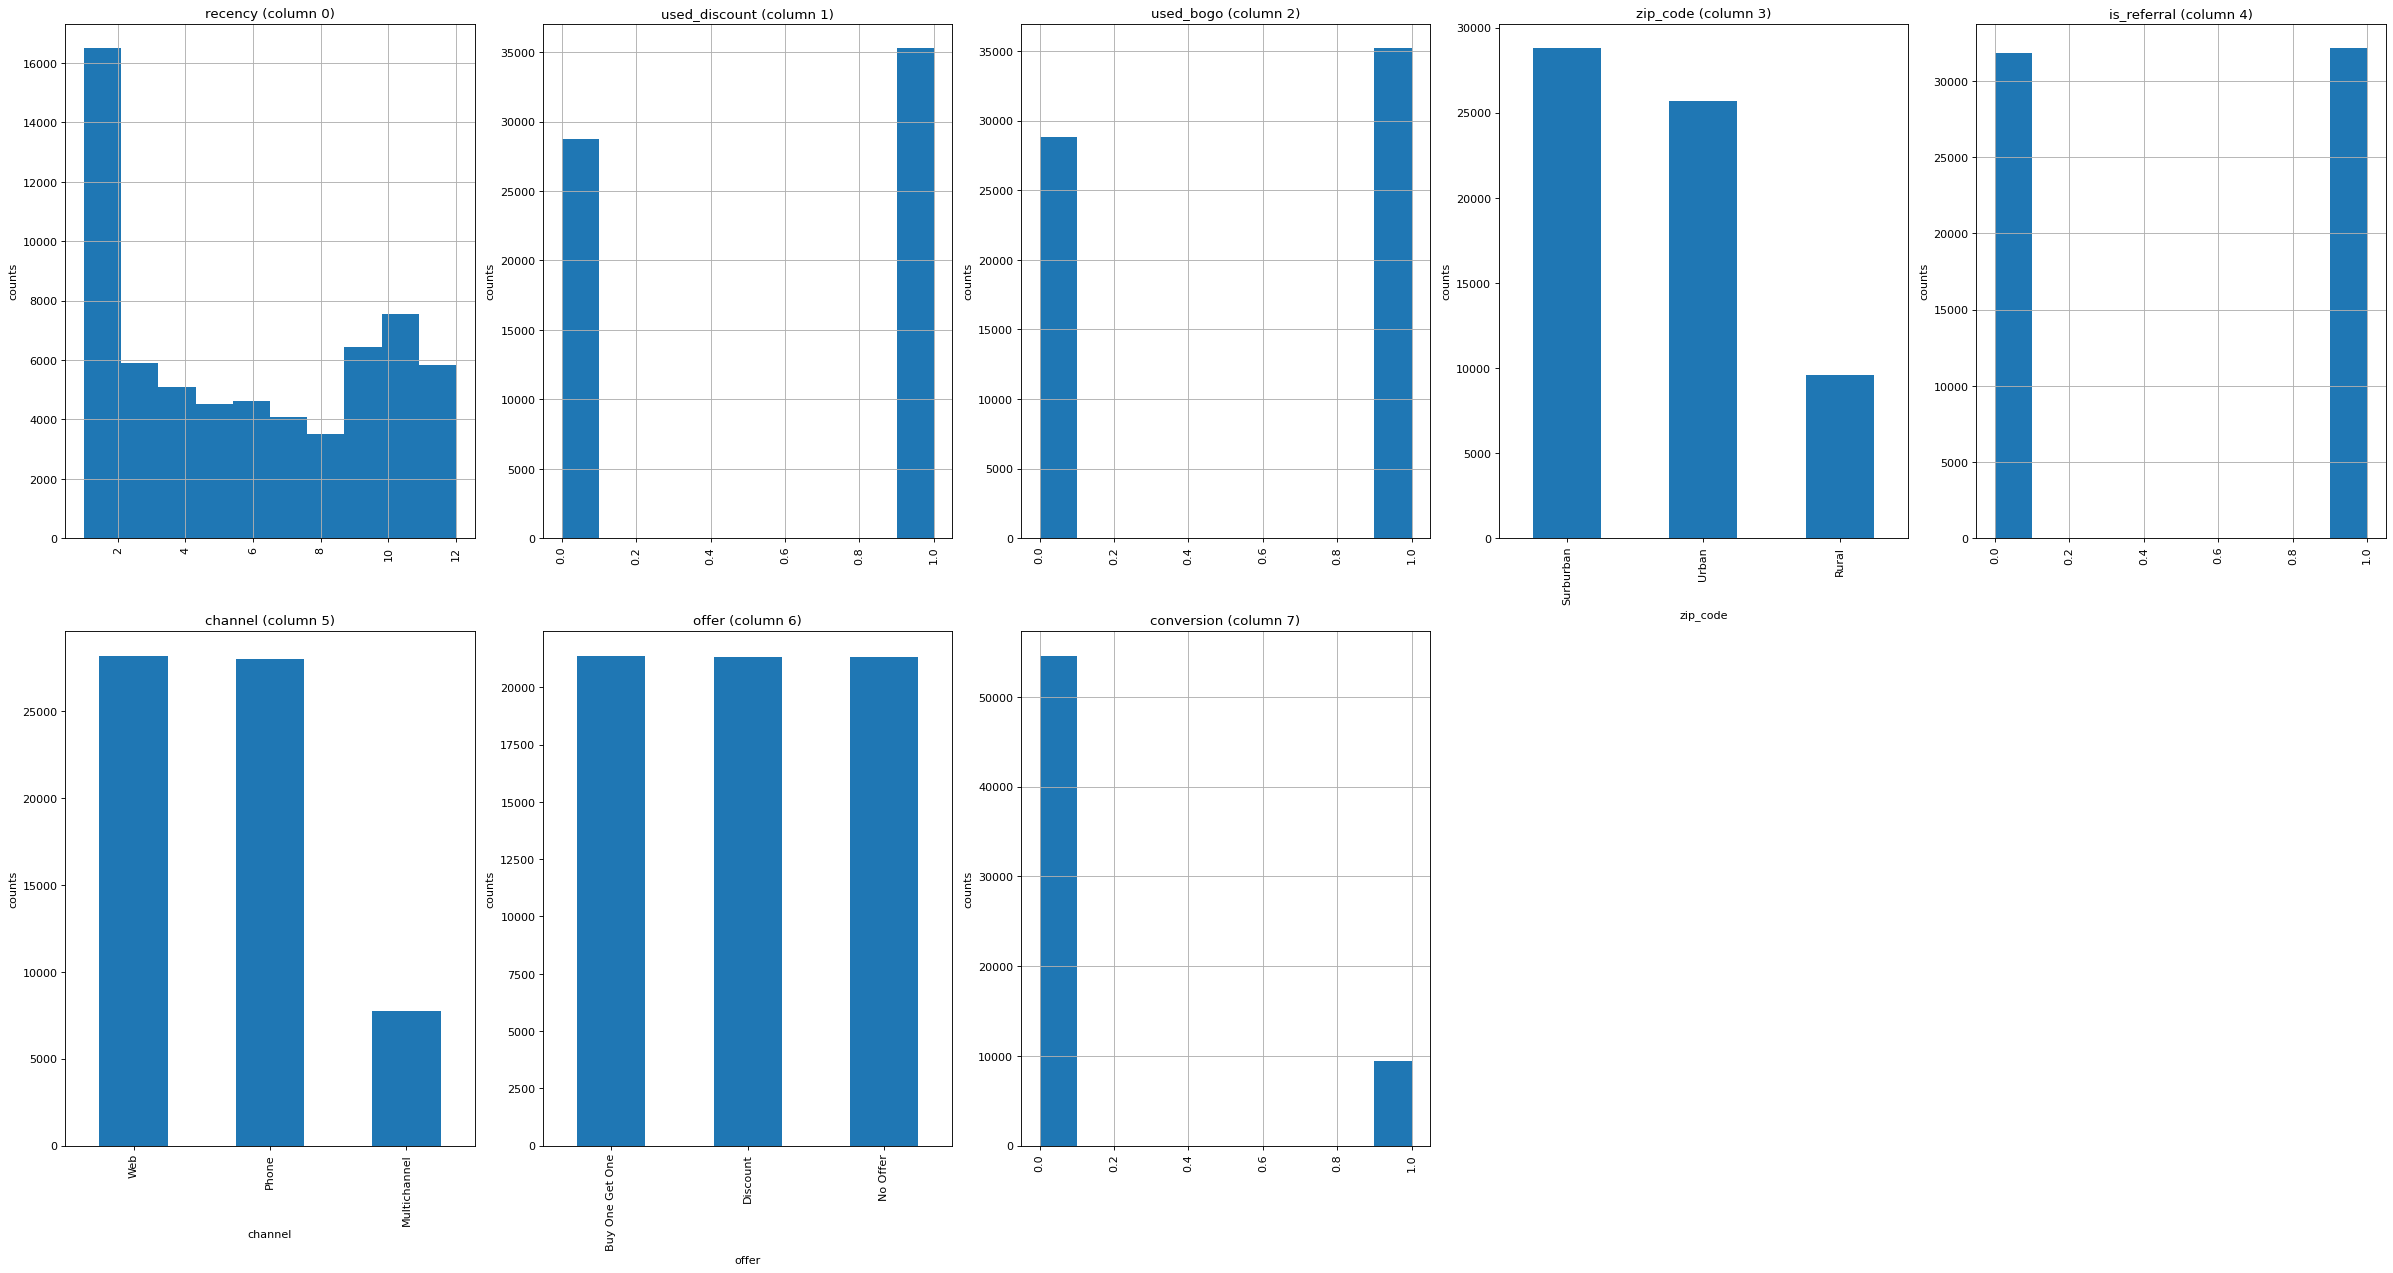

In [23]:
plotPerColumnDistribution(df, 10, 5)

In [31]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

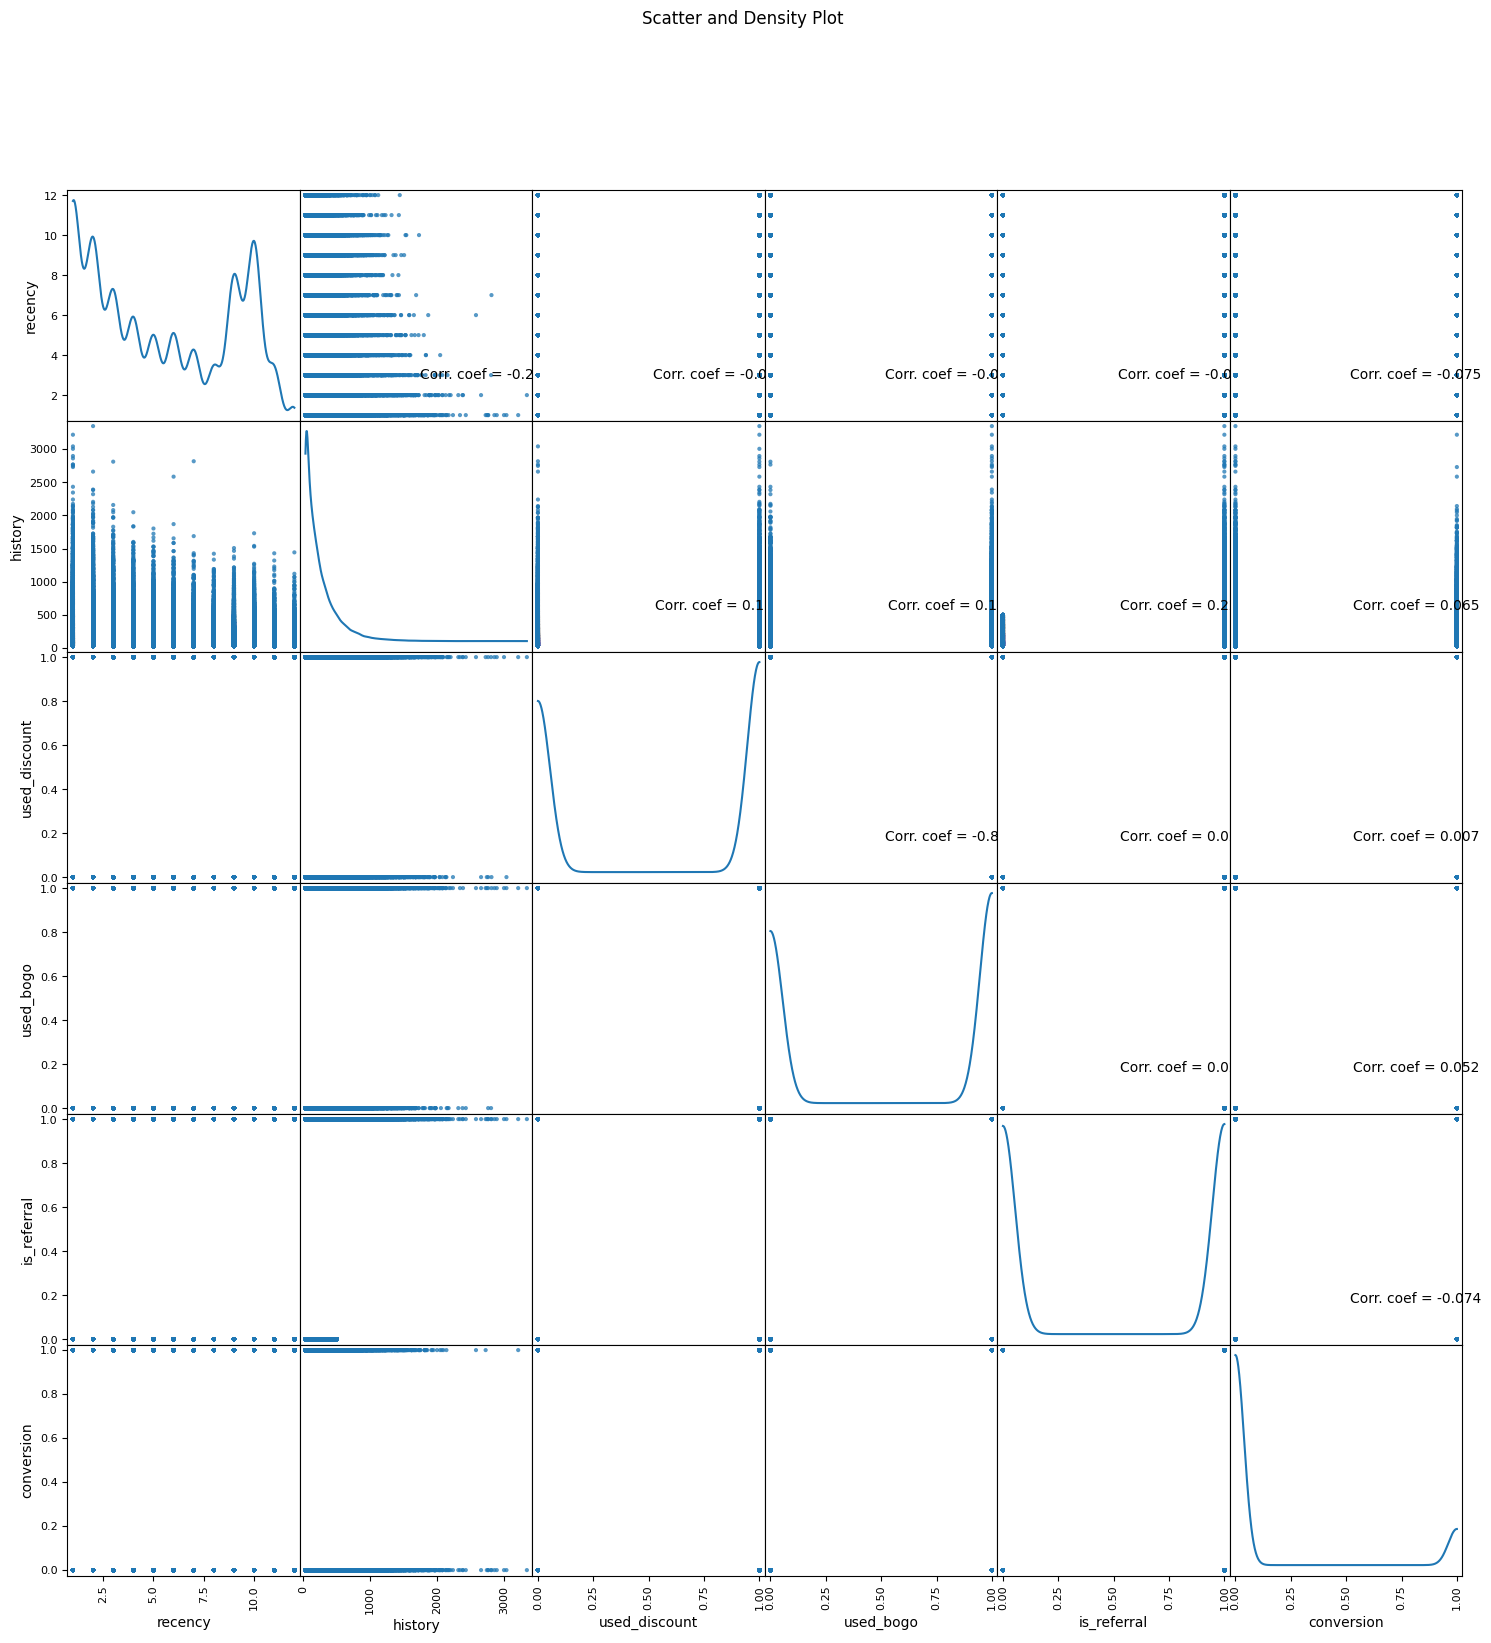

In [32]:
plotScatterMatrix(df, 18, 10)

In [39]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    name = "Customer conversion rate"
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    df['zip_code']=df['zip_code'].astype('category').cat.codes
    df['channel']=df['channel'].astype('category').cat.codes
    df['offer']=df['offer'].astype('category').cat.codes
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {name}', fontsize=15)
    plt.show()

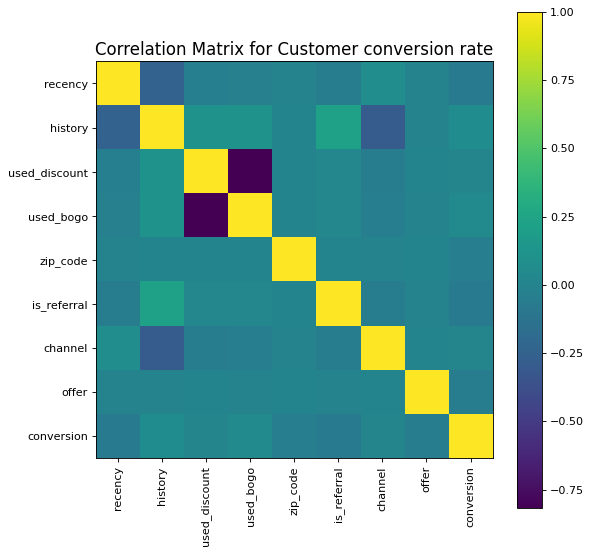

In [40]:
plotCorrelationMatrix(df, 8)

Axes(0.125,0.11;0.775x0.77)


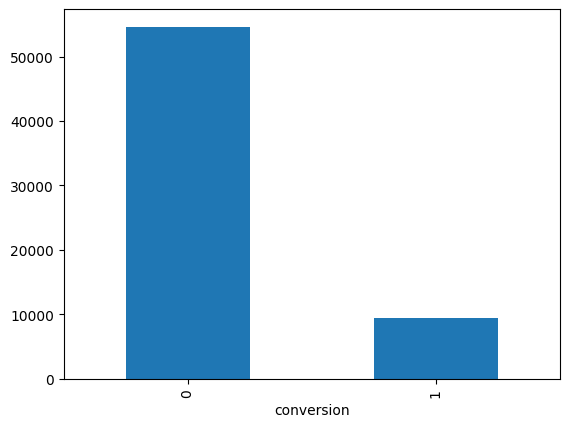

In [10]:
print(df['conversion'].value_counts().plot(kind='bar'))

<Axes: xlabel='channel'>

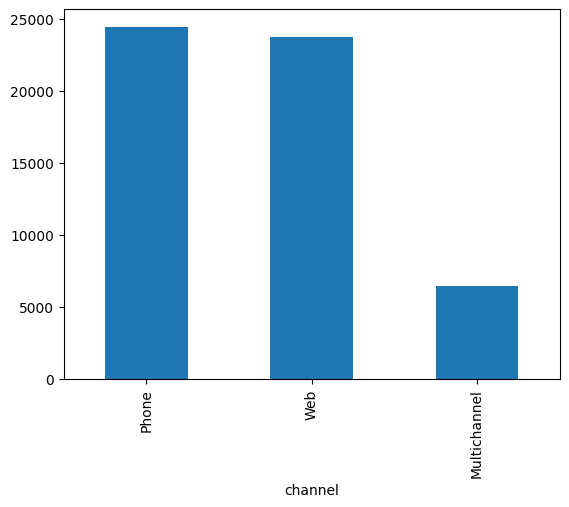

In [14]:
df['channel'][df['conversion'] == 0].value_counts().plot(kind='bar')

<Axes: xlabel='channel'>

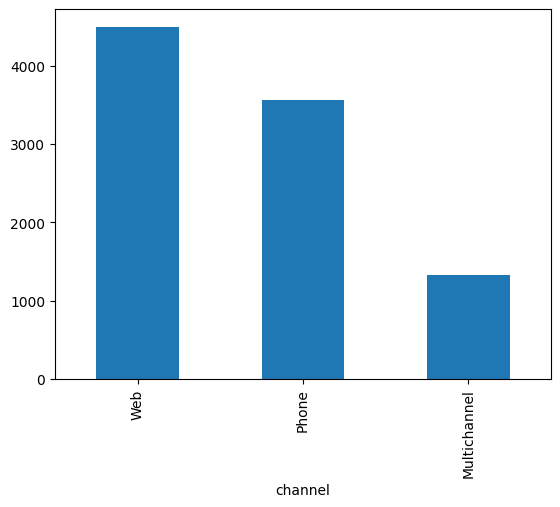

In [15]:
df['channel'][df['conversion'] == 1].value_counts().plot(kind='bar')

<Axes: xlabel='zip_code'>

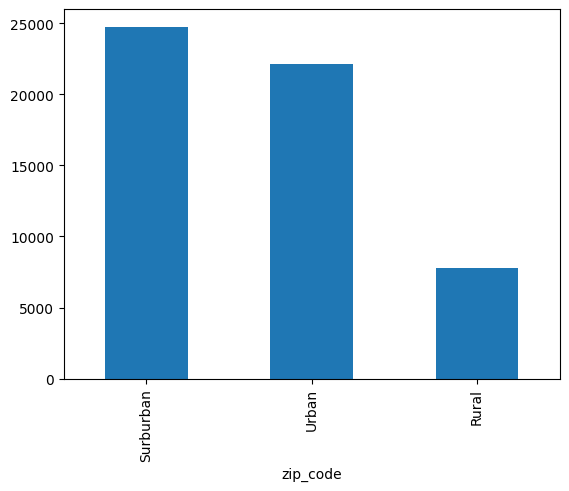

In [16]:
df['zip_code'][df['conversion'] == 0].value_counts().plot(kind='bar')

<Axes: xlabel='zip_code'>

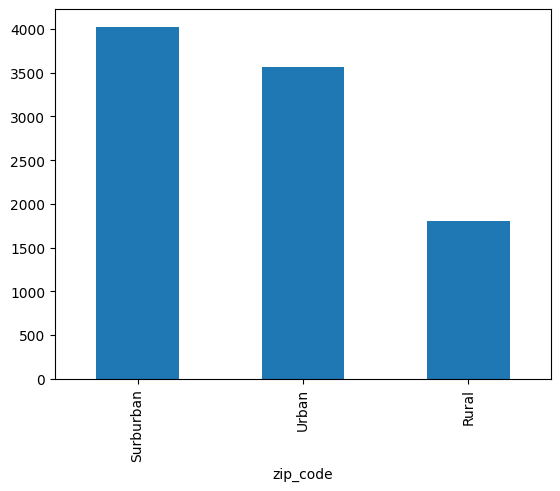

In [17]:
df['zip_code'][df['conversion'] == 1].value_counts().plot(kind='bar')

In [5]:
x_train = df.iloc[:,0:4]
y_train = df['conversion']
x_train,x_test, y_train, y_test = tts(x_train,y_train, test_size = 0.2, random_state = 10,stratify=df['conversion'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(51200, 4)
(12800, 4)
(51200,)
(12800,)


In [6]:
y_train.head()

1363     1
28778    0
30418    0
31898    0
63432    0
Name: conversion, dtype: int64

# Logistic Regression

In [23]:
y_train = np.array(y_train)

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train.ravel())


LogisticRegression()

In [25]:
y_predict = log_reg.predict(x_test)
confusion_matrix(y_test, y_predict)
classification_report(y_test, y_predict)
target_names = ['0', '1']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Grid search Cross Validation

In [27]:
log_reg_param = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,C=c_values)
cv = RSF(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg_param, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/

In [28]:
y_predict_param = grid_result.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Conclusion
- Before hyperparameter tuning, the accuracy of the Logistic Regression model was 85\%. 
- After hyperparameter tuning, there was no change in the accuracy.

# Random forest

In [30]:
rand_for = RandomForestClassifier()
rand_for.fit(x_train,y_train.ravel())

RandomForestClassifier()

In [31]:
y_predict = rand_for.predict(x_test)
confusion_matrix(y_test, y_predict)
classification_report(y_test, y_predict)
target_names = ['0', '1']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     10921
           1       0.17      0.15      0.16      1879

    accuracy                           0.77     12800
   macro avg       0.51      0.51      0.51     12800
weighted avg       0.76      0.77      0.76     12800



## Random Search CV

In [35]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
rand_for_param = RandomForestClassifier()
param = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rand_search_random = RandomizedSearchCV(rand_for_param, param_distributions=param, n_iter=10, cv=5,n_jobs=-1)

rand_search_random.fit(x_train, y_train)
print("Accuracy ",rand_search_random.score(x_test, y_test))
print("Accuracy ",rand_search_random.score(x_train, y_train))

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To 

Accuracy  0.837734375
Accuracy  0.86763671875


In [36]:
y_predict_param = rand_search_random.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     10921
           1       0.18      0.03      0.05      1879

    accuracy                           0.84     12800
   macro avg       0.52      0.50      0.48     12800
weighted avg       0.75      0.84      0.78     12800



## Grid Search Cross validation

In [37]:
rf_gscv = RandomForestClassifier()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,C=c_values)
cv = RSF(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg_param, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/

In [39]:
y_predict_param = grid_search.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Conclusion
- Random forest, without any tuning, gives an accuracy of 86\%.
- Random forest, after randomized search cross validation gives an accuracy of 85\%.
- Random forest, after grid search cross validation also gives an accuracy of 85\%.
- This means that the random forest model, with the default parameters, gives us the best accuracy.

# SVM

In [10]:
svm = LinearSVC()
svm.fit(x_train, y_train.ravel())

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [11]:
y_predict_param = svm.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Grid Search cross validation


In [12]:
param_dist = {'C': np.logspace(-3, 3, 7),
              'max_iter': [10000],
              'tol': [1e-3, 1e-4, 1e-5]}

svm=LinearSVC()
grid_search_svm = GridSearchCV(svm, param_grid=param_dist, cv=10,n_jobs=-1)

grid_search_svm.fit(x_train, y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [10000], 'tol': [0.001, 0.0001, 1e-05]})

In [13]:
y_predict_param = grid_search_svm.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th